# Binary Classification Practice


# Predict Points Above or Below a Quadratic Equation

Create a model that can predict if a random dot is above or below the graph `f(x) = x^2`. Use the following data to train and test your model.

torch.manual_seed(17)
<br>
train_coord = torch.rand(200, 2)

torch.manual_seed(28)
<br>
test_coord = torch.rand(200, 2)

In [18]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np
from pathlib import Path

In [3]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using device: {device}")

torch.manual_seed(17)
train_coord = torch.rand(200, 2, 
                         requires_grad=True,
                         device=device)

torch.manual_seed(28)
test_coord = torch.rand(200, 2, 
                        requires_grad=True, 
                        device=device)

Using device: cpu


In [4]:
class Model(nn.Module):

    def __init__(self, input_size, hidden_size, output_size=1):
        super().__init__()

        self.layer1 = nn.Linear(input_size, hidden_size)
        self.activation = nn.ReLU()
        self.sigmoid = nn.Sigmoid()
        self.layer2 = nn.Linear(hidden_size, hidden_size)
        self.layer3 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = self.layer1(x)
        x = self.activation(x)
        x = self.layer2(x)
        x = self.activation(x)
        x = self.layer3(x)
        x = self.sigmoid(x)
        return x
    

def train_model(model, data, label, loop, lr=1.1):
    criterion = nn.BCELoss()
    optimizer = torch.optim.SGD(model.parameters(), lr)
    model.train()

    for epoch in range(loop):
        optimizer.zero_grad()
        output = model(data).squeeze()
        loss = criterion(output, label)

        loss.backward()
        optimizer.step()

        if (epoch+1) % (loop/5) == 0:
            print(f"Ran {epoch+1} loops; loss: {loss.item()}")


def test_model(model, data, label):
    model.eval()
    with torch.inference_mode():
        output = model(data).squeeze()
        
        accuracy = (output.round() == label).float().mean()
        print("Accuracy {:.2f}".format(accuracy * 100))
            


def f(x):
    return torch.pow(x, 2)


def generate_labels(input):
    x = input[:, 0]
    y = input[:, 1]
    return (y > f(x)) * 1.


In [5]:
# print(generate_labels(train_coord))
model = Model(train_coord.shape[-1], hidden_size=100) # include parameters
train_model(model, train_coord, generate_labels(train_coord), 10000)
test_model(model, test_coord, generate_labels(test_coord))

Ran 2000 loops; loss: 0.016085030511021614
Ran 4000 loops; loss: 0.004689580295234919
Ran 6000 loops; loss: 0.0012223442317917943
Ran 8000 loops; loss: 0.000528296863194555
Ran 10000 loops; loss: 0.00030506079201586545
Accuracy 99.50


Accuracy 99.00


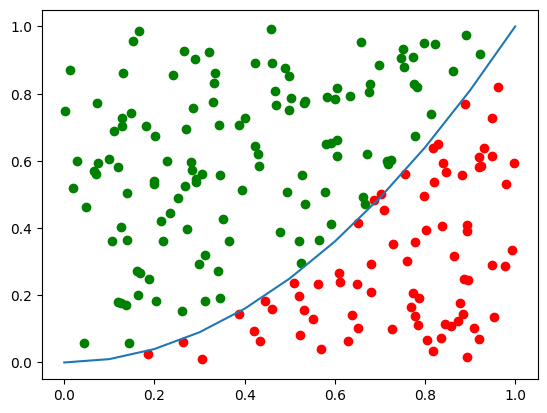

In [26]:
# torch.manual_seed(28)
test_coord = torch.rand(200, 2, 
                        requires_grad=True,
                        device=device)

x_plot = np.array(test_coord[:, 0].detach())
y_plot = np.array(test_coord[:, 1].detach())

x_graph = torch.arange(0, 1.1, 0.1)

model.eval()
with torch.inference_mode():
    output = np.array(model(test_coord).squeeze())
condition = output > 0.5

test_model(model, test_coord, generate_labels(test_coord))
plt.scatter(x_plot[condition], y_plot[condition], c='g', label='Above')
plt.scatter(x_plot[~condition], y_plot[~condition], c='r', label='Below')

plt.plot(x_graph, f(x_graph))
plt.show()

In [38]:
# save the model's state dict aka its weights and biases

MODEL_PATH = Path("state dictionary")
MODEL_PATH.mkdir(parents=True, exist_ok=True)

MODEL_NAME = "Predict_Points_Above_or_Below_a_Quadratic_Equation_State_Dict.pt"
MODEL_SAVE_PATH = MODEL_PATH / MODEL_NAME

torch.save(model.state_dict(), MODEL_SAVE_PATH)


In [39]:
# create a new model 
model_1 = Model(train_coord.shape[-1], hidden_size=100)

# load the original model's state_dict()
model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))

C:\Users\chino\AppData\Local\Temp\ipykernel_9416\2060917169.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model_1.load_state_dict(torch.load(f=MODEL_SAVE_PATH))


<All keys matched successfully>

In [40]:
model_1.eval()
with torch.inference_mode():
    model_1_pred = np.array(model_1(test_coord).squeeze())

test_model(model_1, test_coord, generate_labels(test_coord))


Accuracy 99.00


# Predict if the image has a dog 

image tensors follow the format shape = [batch_size, color_channel, width, height]. 
- batch_size refers to how many images to look at